In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas

In [2]:
df = pd.read_csv("../data/cook_county_cleaned3.csv")
gdf = geopandas.read_file("../data/cook_county_with_geometries4.geojson")
cook_county = geopandas.read_file("../data/Cook_County_Border.geojson")
chicago_border = geopandas.read_file("../data/chicago_border.geojson")
settlements = geopandas.read_file("../data/settlements.json")

In [3]:
# Remove duplicated entries
df.drop_duplicates(subset=["Purchaser", "Aliquot Parts or Lot", 'Section Number', 'Township', 'Range', 'Meridian',], inplace=True)

In [4]:
df = df.loc[(~df['Voided'])&(~df['Duplicate'])]

In [5]:
# Make sure we have acres and price as numeric values
df['acres_float'] = pd.to_numeric(df['Acres'],errors='coerce') 
df['price_float'] = pd.to_numeric(df['Total Price'],errors='coerce')
gdf['acres_float'] = pd.to_numeric(gdf['Acres'],errors='coerce') 
gdf['price_float'] = pd.to_numeric(gdf['Total Price'],errors='coerce') 

In [6]:
# Make a datetime version of date of purchase
df['Date'] = pd.to_datetime(df['Date of Purchase'], infer_datetime_format=True, errors="coerce")

In [7]:
# Generate Map from this?
purchases_by_year = df.groupby(df['Date'].dt.year)['Cleaned Name'].count()

# Purchasers

In [8]:
def groupby_cat(df, cat):
    new_df = df.groupby(by=cat).agg({"Cleaned Name": 'count', "acres_float": 'sum', "price_float": 'sum'})
    return new_df.rename(columns={"Cleaned Name": "Purchases",\
                                  "acres_float": "Total Acres", "price_float": "Total Spent"})

In [9]:
purchasers = groupby_cat(df, "Cleaned Name")

## Most Acres

In [10]:
purchasers.sort_values(by="Total Acres", ascending=False).head(10)

,Purchases,Total Acres,Total Spent
Cleaned Name,,,
EGAN WILLIAM B,117,10127.87,67118.72
HOARD SAMUEL,146,8442.01,27651.54
LEWIS JOHN,116,7214.22,12347.98
HUBBARD ELIJAH K,54,5711.46,8185.14
FOSTER JOHN H,82,4852.81,8823.82
DYER THOMAS,60,4290.46,5406.97
WADSWORTH JULIUS,61,4214.80,8268.53
PEARSONS HIRAM,87,3587.01,23509.04
BLANCHARD FRANCIS G,35,3519.31,9891.53


William Bradshaw Egan and Samuel Hoard were both early politicians in Illinois. 

In [11]:
def plot_individuals_holdings(ax, name):
    cook_county.plot(ax=ax, color="white", edgecolor="black", linewidth=0.25)
    ax.set_aspect('equal')
    ax.title.set_text(name)
    ax.set_axis_off()
    gdf.loc[gdf['Cleaned Name'] == name].plot(ax=ax)

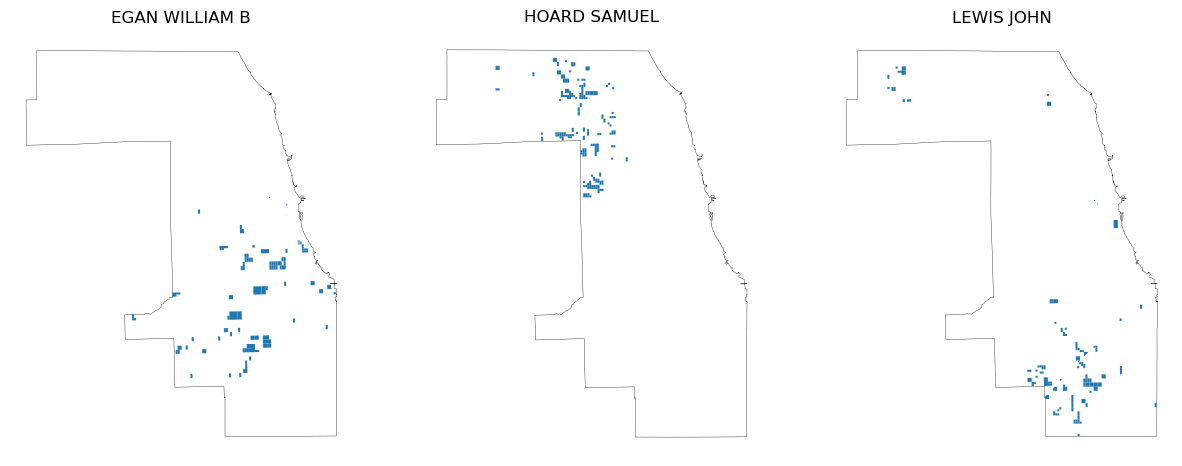

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,30))
plot_individuals_holdings(ax1, "EGAN WILLIAM B")
plot_individuals_holdings(ax2, "HOARD SAMUEL")
plot_individuals_holdings(ax3, "LEWIS JOHN")

## Most Purchases

In [13]:
purchasers.sort_values(by="Purchases", ascending=False).head(10)

,Purchases,Total Acres,Total Spent
Cleaned Name,,,
HOARD SAMUEL,146,8442.01,27651.54
EGAN WILLIAM B,117,10127.87,67118.72
LEWIS JOHN,116,7214.22,12347.98
PEARSONS HIRAM,87,3587.01,23509.04
FOSTER JOHN H,82,4852.81,8823.82
WADSWORTH JULIUS,61,4214.80,8268.53
DYER THOMAS,60,4290.46,5406.97
HUBBARD ELIJAH K,54,5711.46,8185.14
KINZIE JOHN H,50,1875.46,4055.29


Note Cook, Riddle, Stinson, Loomis, Gooding, all made alot of purchases but don't have a lot of acreage to show for it. Cooks purchases came in lots mostly without a township or range, but labeled CHI, most of Riddles came in 39N 14E, some labeled CHI. All of Stinsons were in 39N 14E. Loomis had some in 38N 14E in addition to 39N. William Gooding also had alot labeled CHI with no township or range. 

## Most Spent

In [14]:
purchasers.sort_values(by="Total Spent", ascending=False).head(10)

,Purchases,Total Acres,Total Spent
Cleaned Name,,,
LAFLIN MATTHEW,15,0.00,146720.00
EGAN WILLIAM B,117,10127.87,67118.72
PECK PHILIP F W,39,1873.73,42968.16
STEWART ROYAL,4,0.00,42060.00
DODGE JOHN C,21,220.10,41106.60
IGLEHART NICHOLAS P,31,209.42,40499.00
RIDDLE JOHN S,40,0.00,38715.00
COCHRAN JAMES W,40,1834.81,37185.90
THROOP AMOS G,35,80.00,36315.00


Laflin, Peck, and Stewart all spent alot of money on few purchases with little to no acreage. Those purchases were mostly lots or block inside the city of chicago which often didn't have an acreage listed (but would likely not be a lot of acres). 

# By Last Name

In [15]:
df['Last Name'] = df['Purchaser'].str.split(" ", expand=True)[0]

In [16]:
last_name = groupby_cat(df, "Last Name")

In [17]:
last_name.sort_values(by="Total Acres", ascending=False).head(10)

,Purchases,Total Acres,Total Spent
Last Name,,,
EGAN,128,9907.19,71390.77
LEWIS,151,9113.75,17766.64
HOARD,146,8442.01,27651.54
HUBBARD,91,8223.49,17213.81
SMITH,128,6515.56,38991.71
BROWN,80,5779.75,20739.15
FOSTER,117,5578.69,10041.48
RUSSELL,43,5508.36,10423.95
ANDREWS,45,4449.98,5946.27


By last name doesn't seem to reveal a lot more as the list looks very similar to the purchases by individuals with a mix of more common last names. 

# Purchases Overtime

In [18]:
gdf['Date'] = pd.to_datetime(gdf['Date of Purchase'], errors="coerce")
gdf['Decade'] = (df['Date'].dt.year//10)*10
df['Date'] = pd.to_datetime(df['Date of Purchase'], errors="coerce")

In [19]:
gdf['Year'] = gdf['Date'].dt.year
df['Year'] = df['Date'].dt.year

In [20]:
by_year = groupby_cat(df, "Year")

## Purchases by Year

<AxesSubplot:title={'center':'Acres Purchased By Year'}, xlabel='Year'>

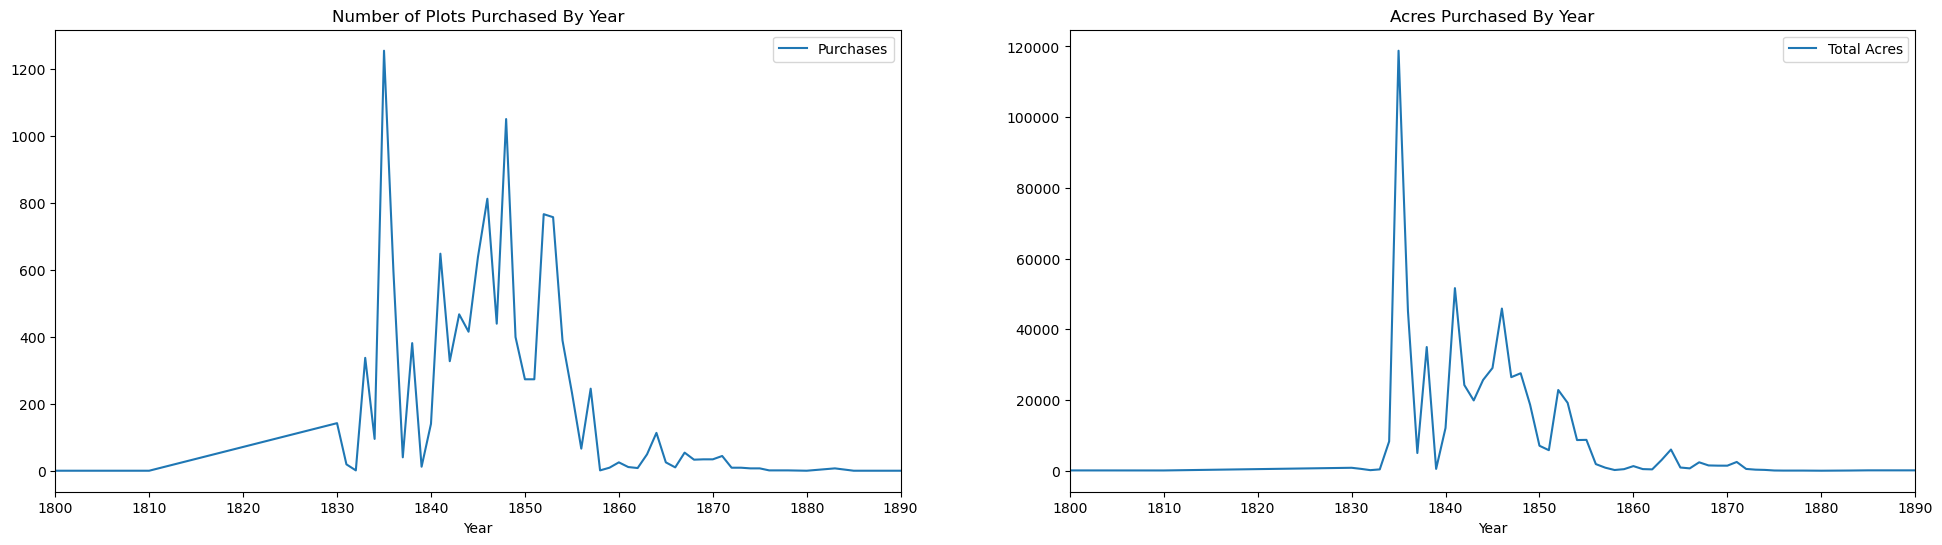

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(24,6))
ax1.set_title("Number of Plots Purchased By Year")
ax2.set_title("Acres Purchased By Year")
by_year.plot(y="Purchases", xlim=(1800, 1890), ax=ax1)
by_year.plot(y="Total Acres", xlim=(1800, 1890), ax=ax2)

There were spikes in the amount of purchases (perhaps due to when lots were made available) in various years. Most lots were purchsaes between 1830 and 1860. 

<AxesSubplot:title={'center':'Year Plot Purchased'}>

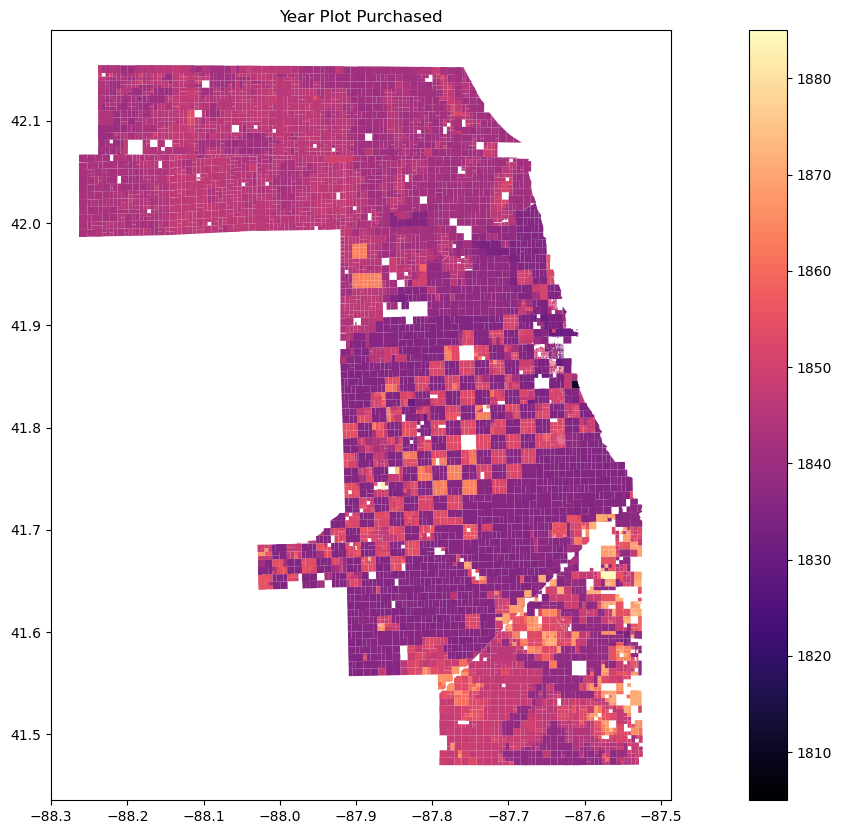

In [22]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title("Year Plot Purchased")
gdf[(gdf['Year'] > 1800)&(gdf['Year'] < 1890)].plot(column="Year",\
                                                        ax=ax, cmap="magma", legend=True,)

Plots tended to be purchased around the same time as adjacent plots, with plots closer to the city being purchased earlier

<AxesSubplot:title={'center':'Year Plot Purchased (Chicago City Only)'}>

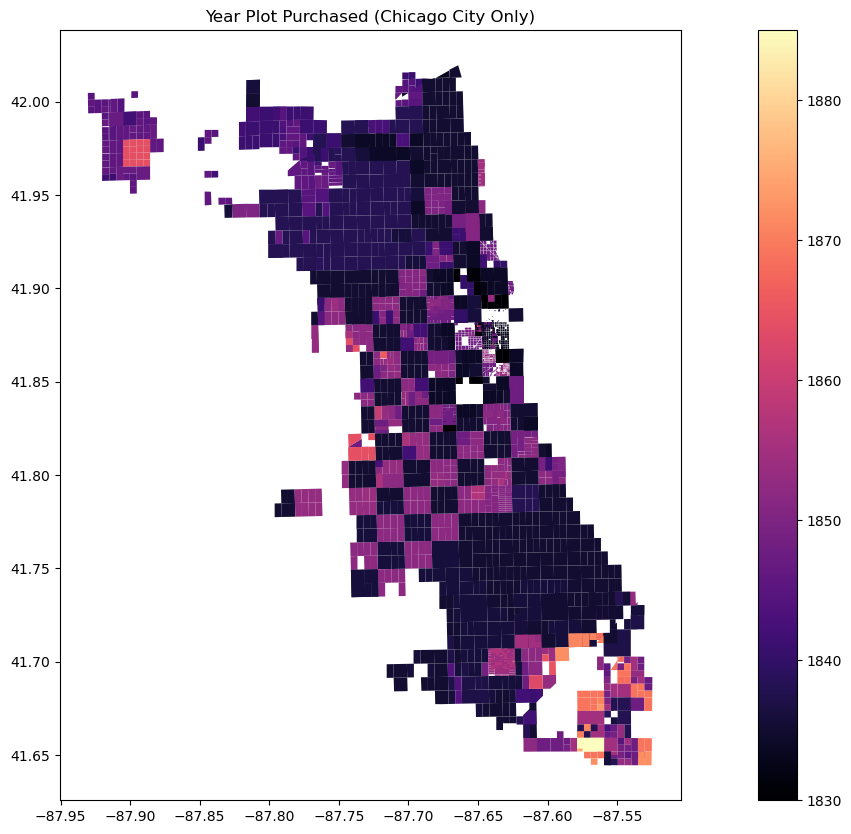

In [23]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title("Year Plot Purchased (Chicago City Only)")
gdf_city = gdf.sjoin(chicago_border, how="inner", predicate="within")


gdf_city[(gdf_city['Year'] > 1800)&(gdf_city['Year'] < 1890)].plot(column="Year",\
                                                        ax=ax, cmap="magma", legend=True,)

# Purchases in Settlements

In [24]:
settlements.head()

,settlement,year,geometry
0,CHICAGO,1837,"POLYGON ((-87.62466 41.91135, -87.62674 41.911..."
1,ROGERS PARK,1893,"POLYGON ((-87.66196 41.99817, -87.66183 41.998..."
2,LAKE,1889,"POLYGON ((-87.62642 41.82371, -87.62759 41.823..."
3,WEST RIDGE,1893,"POLYGON ((-87.67684 41.99796, -87.67690 41.998..."
4,HYDE PARK,1889,"POLYGON ((-87.62278 41.68164, -87.62275 41.680..."


In [25]:
lots_with_settlement = gdf.sjoin(settlements, how="inner", predicate="within")

In [26]:
def get_top_purchasers(settlement):
    settlement_by_purchaser = groupby_cat(lots_with_settlement[lots_with_settlement['settlement'] == settlement], 'Cleaned Name')
    return settlement_by_purchaser.sort_values(by="Total Acres", ascending=False).head(10)

def plot_settlements_with_purchasers(ax, settlement, names):
    settlements[settlements['settlement'] == settlement].plot(ax=ax, color="white", edgecolor="black")
    mask = (lots_with_settlement['Cleaned Name'].isin(names)) & (lots_with_settlement['settlement'] == settlement)
    lots_with_settlement[mask].plot(ax=ax, column='Cleaned Name', legend=True, legend_kwds={"loc": 1})
    
    
def display_settlement(settlement):
    df = get_top_purchasers(settlement)
    names = df.index.tolist()[0:3]
    print(df)
    fig, ax = plt.subplots(figsize=(5,10))
    plot_settlements_with_purchasers(ax, settlement, names)
    

## Hyde Park

                     Purchases  Total Acres  Total Spent
Cleaned Name                                            
HUBBARD ELIJAH K            21      2451.22      3669.22
DOUGLAS STEPHEN A           12      1027.90      2569.70
EGAN WILLIAM B              18       885.09      6462.72
ASK KUM IN                   1       572.61         0.00
BLANCHARD FRANCIS G          2       480.00       600.00
WHITFORD LOT C              10       425.76      3869.50
WILLIAMS LUKE L              4       400.00         0.00
SMITH AMBROSE Y              4       372.23       465.29
PEARSONS HIRAM               4       338.11       422.64
FAULKNER JOSEPH M            2       320.00       400.00


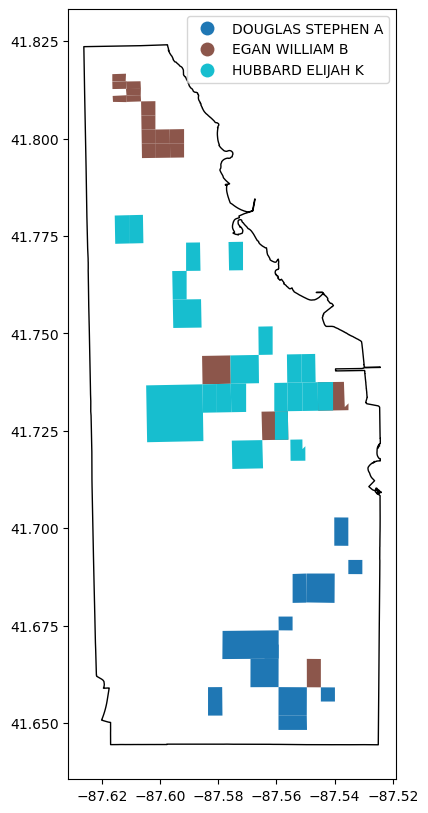

In [27]:
display_settlement("HYDE PARK")

Of note, William Egan and Hiram Perasons were both big purchasers in general. A cursory googling of Elijah Hubbard only revealed that he was in real estate. Obviously most notable is the politician Stephan A Douglas. 

## Lakeview

                     Purchases  Total Acres  Total Spent
Cleaned Name                                            
RHINES HENRY                 3        320.0        424.0
BRONSON ARTHUR               6        320.0       3280.0
OGDEN WILLIAM B              8        320.0       4320.0
BRITTON HIRAM Z              2        240.0        300.0
PRICE JEREMIAH               3        240.0        300.0
NICHOLS GEORGE               2        160.0        220.0
HITCHCOCK SYLVESTER          2        160.0        428.0
WILLIAMSON PHILIP            2        160.0        200.0
TUCKER ALEXANDER H           1        160.0        200.0
ROWLEY HEMAN A               1        160.0        200.0


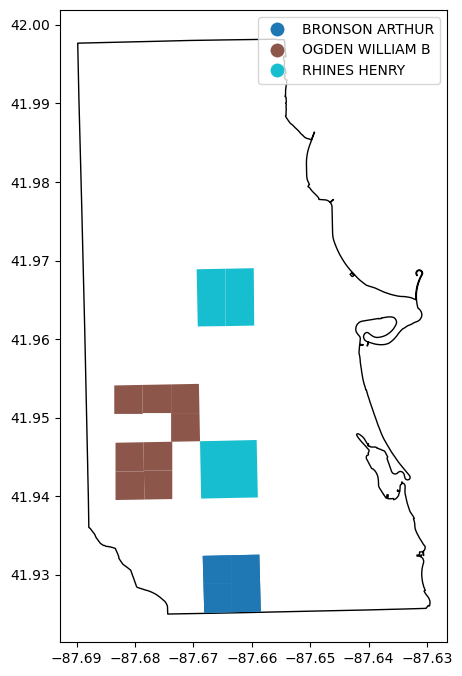

In [28]:
display_settlement("LAKE VIEW")

## West Ridge

                 Purchases  Total Acres  Total Spent
Cleaned Name                                        
ROGERS PHILIP            5       180.66       225.83
ROSE RUSSEL              1       160.00       200.00
HOOD DAVID               2        80.00       100.00
ROHRER SAMUEL            2        78.02        97.36
SMITH JOHN               1        41.05        51.31
TRADER MOSES S           1        40.00        50.00
TURNER JOHN B            1        39.84        49.80
TURNER LEIGHTON          1        39.84        49.80
PHILLIPS JACOB           1        39.03        48.79
WILLIAMS SAMUEL          1        39.03         0.00


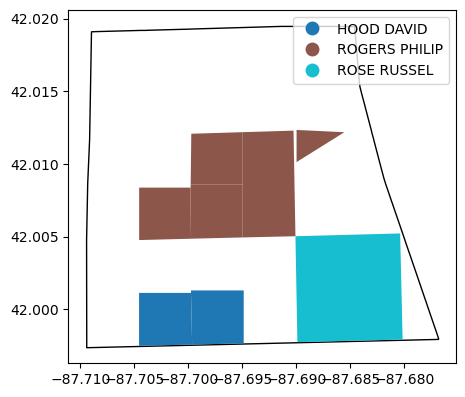

In [29]:
display_settlement("WEST RIDGE")

Perhaps most notable is Rogers Parks namesake Philip Rogers. His holdings (according to wikipedia) passed to his son in law, Patrick Touhy. Although he didn't purchase any land in the original Rogers Park, West Ridge bordered the park

## Lake

                     Purchases  Total Acres  Total Spent
Cleaned Name                                            
EGAN WILLIAM B              24      2159.30     10800.00
JOHNSTON WILLIAM            21      1680.00      6720.00
BEERS CYRUS                 13       880.00      6520.00
RUSSELL JOHN B F             2       720.33       900.41
HIGGINSON S C                8       640.00      2560.00
BROWN WM                     2       480.00       600.00
BLANCHARD FRANCIS G          4       480.00       600.00
GOODRICH GRANT               4       480.00       776.00
HUBBARD THOMAS R             4       400.61       596.82
HUBBARD ELIJAH K             5       400.30       520.40


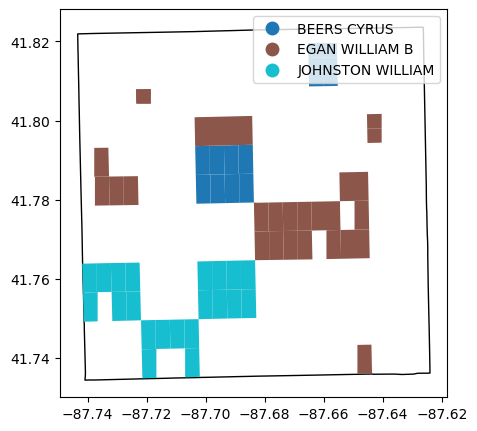

In [30]:
display_settlement("LAKE")

Egan purchased alot of his plots in this area.

## Jefferson

                      Purchases  Total Acres  Total Spent
Cleaned Name                                             
DYER THOMAS                   9       640.00       800.00
WADSWORTH JULIUS              9       640.00       800.00
STRACHAN PATRICK              5       640.00       800.00
FERGUSON ALEXANDER            3       480.00       600.00
LOVETT JOSEPH                 3       400.00       500.00
WENTWORTH ELIJAH SEN          3       357.06       714.70
ABBOTT SAMUEL S               2       320.00       400.00
WENTWORTH ELIJAH              5       288.52       360.65
BOWEN SYLVESTER               2       249.99       312.49
TALLEY ALFRED M               3       240.00       300.00


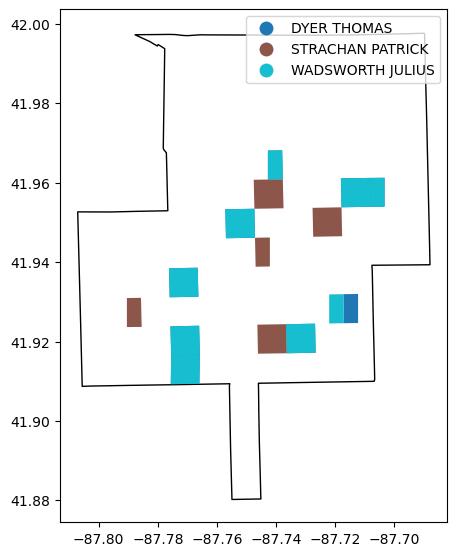

In [31]:
display_settlement('JEFFERSON')

## SOUTH ENGLEWOOD

                 Purchases  Total Acres  Total Spent
Cleaned Name                                        
GARRETT A ET CO          1         80.0        100.0
GERARD MOSES             1         80.0        100.0
MCMARTIN JAMES           1         80.0        100.0


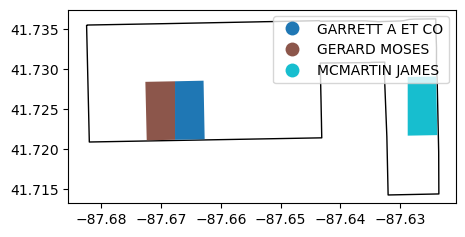

In [32]:
display_settlement("SOUTH ENGLEWOOD")

## Washington Heights

                   Purchases  Total Acres  Total Spent
Cleaned Name                                          
BLACKSTONE JOHN            2        160.0        200.0
GARDNER JEFFERSON          1        160.0        200.0
ROWLEY JIRCH               2        160.0        200.0


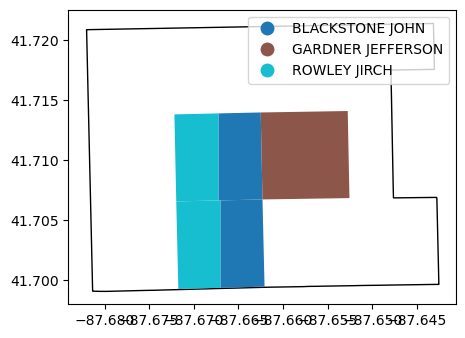

In [33]:
display_settlement("WASHINGTON HEIGHTS")

## Morgan Park

                   Purchases  Total Acres  Total Spent
Cleaned Name                                          
ANDREWS DAVID              2        240.0       300.00
BLACKSTONE JOHN            1        160.3       200.38
MORGAN THOMAS              2        160.0       200.00
HAYES JOEL N               1         80.0       100.00
HEACOCK RUSSELL E          1         80.0       100.00
KELLOGG ABEL A             1         80.0       100.00
KIMBALL SAMUEL I           1         80.0       100.00


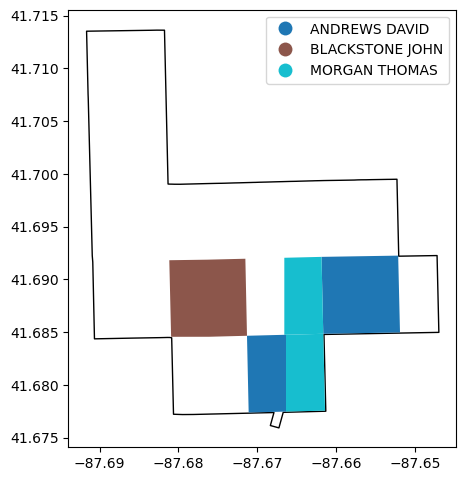

In [34]:
display_settlement("MORGAN PARK")